In [1]:
#Prepare Quantum States

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

def pure_state():
    eps = 1e-7
    rand_ket = qt.rand_ket_haar(4)
    rho_p = qt.ket2dm(qt.Qobj(rand_ket))
    rho_p = (1-eps)*rho_p + (eps/4)*np.eye(4)
    return np.array(rho_p)

def mixed_state(d):
    
    """d = dimension of matrix
    """
    G = np.random.normal(0, 1, [d,d]) + 1j*np.random.normal(0, 1, [d,d])
    G = np.matrix(G)
    rho_m = (G*G.H)/np.trace(G*G.H)
    return rho_m

In [2]:
#Simulate Noise via Variance

def eig_val_corr(state):
    
    """ state = nxn dimensional state
        Corrects state by truncating negative eigenvalues and reconstructs normailized positive
        eigenvalued eigenvectos' states
    """
    if np.sum(np.linalg.eig(state)[0].real < 0) > 0 or np.sum(np.linalg.eig(state)[0].real > 1):
        eig_val, eig_vec = np.linalg.eig(state)
        eig_val = eig_val.real
        eig_val[eig_val < 0] = 0
        eig_val = eig_val/np.sum(eig_val)
        
        d = state.shape[0]
        state = np.zeros([d,d], dtype = 'complex')
        for ij in range(d):
            state += eig_val[ij]*np.matmul(eig_vec[ij].reshape(d,1), np.matrix(eig_vec[ij].reshape(d,1)).H)
            
    return state
            
def noise_state(state, var):
    
    """ state = 4x4 quantum state
        var = scalar value. High var = high noise in state to be measured.
    """
    d = state.shape[0]
    noisy_state_raw = state + np.random.normal(0, var, [d,d]) + 1j*np.random.normal(0, var, [d,d])
    
    if np.sum(np.linalg.eig(noisy_state_raw)[0].real < 0) > 0:
        state = eig_val_corr(noisy_state_raw)
    else:
        state = noisy_state_raw
            
    return state

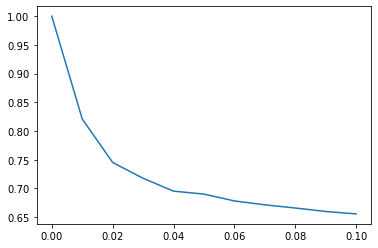

In [3]:
#checking relation between var and infidelity

fid = np.zeros([11, 1000])
k=0
for ij in range(11):
    var = 0.01*ij
    for jk in range(1000):
        rho = mixed_state(d=8)
        rho_noisy = noise_state(rho, var)

        fid[ij, jk] = qt.fidelity(qt.Qobj(rho), qt.Qobj(rho_noisy))
        
plt.plot(0.01*np.arange(11), np.mean(fid, axis=1))

In [5]:
def pauli_basis():
    
    I = np.array([[1, 0],
                  [0, 1]], dtype = 'complex')
    X = np.array([[0, 1],
                  [1, 0]], dtype = 'complex')
    Y = np.array([[0, -1j],
                  [1j, 0]], dtype = 'complex')
    Z = np.array([[1, 0],
                  [0, -1]], dtype = 'complex')
    pauli = np.array([I, X, Y ,Z], dtype = 'complex')
    
    return pauli

def pauli_words(optrs, qbts):
    if qbts == 1:
        return optrs
    else:
        d = optrs.shape[-1]
        pauli = pauli_basis()
        temp_optrs = np.zeros([(2*d)**2, d*2, d*2], dtype = 'complex')
        optrs = optrs.reshape([d**2, d, d])
        for i in range(4):
            for j in range(d**2):
                temp_optrs[(d**2)*i + j] = np.kron(pauli[i], optrs[j])
        rep_4 = int(np.log10((2*d)**2)/np.log10(4))
        temp_optrs = temp_optrs.reshape(np.append(np.repeat(4, rep_4), [d*2, d*2]))
        return pauli_words(temp_optrs, qbts - 1)


def counts_to_bloch(rho_noisy, optrs, shots, qbts):
    
    mn_rnd = np.zeros([4**qbts, 2**qbts])
    mn_eval = np.zeros([4**qbts, 2**qbts])

    for ii in range(4**qbts):
        rr = np.zeros([1, 2**qbts])
        for jj in range(2**qbts):
            e_val, e_vec = np.linalg.eig(optrs.reshape(64, 8, 8)[ii])
            e_vec = np.matrix(e_vec[:,jj]).transpose()
            e_vec_mat = e_vec*e_vec.getH()
            rr[0, jj] = np.real(np.trace(np.matmul(rho_noisy, e_vec_mat)))
        rr = np.round(rr[0], 8)
        rr[rr < 0] = 0
        rr = rr/np.sum(rr)
        rr[-1] = 1 - np.sum(rr[:-1])
        if np.sum(rr < 0) > 0:
            print(rr)
        rr[rr < 0.0000000001] = 0
        mn_rnd[ii, :] = np.random.multinomial(shots, rr)
        mn_eval[ii, :] = e_val.real

    return np.sum(mn_rnd*mn_eval, axis=1)/shots

In [6]:
data_pts = 10000
d = 8
var_vals = 5
k = np.zeros(64)
qbts = 3
shots = 100

optrs = pauli_words(pauli_basis(), qbts)

var_0_L = np.zeros([data_pts, 64])
var_0_I = np.zeros([data_pts, 64])
v0 = 0

var_1_L = np.zeros([data_pts, 64])
var_1_I = np.zeros([data_pts, 64])
v1 = 0

var_2_L = np.zeros([data_pts, 64])
var_2_I = np.zeros([data_pts, 64])
v2 = 0

var_3_L = np.zeros([data_pts, 64])
var_3_I = np.zeros([data_pts, 64])
v3 = 0

var_4_L = np.zeros([data_pts, 64])
var_4_I = np.zeros([data_pts, 64])
v4 = 0

for ij in range(data_pts):
    
    rho = mixed_state(d)
    
    for jk in range(var_vals):
        var = 0.01*jk
        rho_noisy = noise_state(rho, var)
        
        temp_labels = np.zeros([4,4,4])
        temp_inputs = np.zeros([4,4,4])
        
        for i in range(4):
            for j in range(4):
                for k in range(4):
                    temp_labels[i, j, k] = np.trace(np.matmul(optrs[i,j,k], rho))        
         
        if jk == 0:
            var_0_L[v0] = temp_labels.reshape(64)
            var_0_I[v0] = counts_to_bloch(rho_noisy,optrs, shots, qbts)
            v0 += 1
        
        if jk == 1:
            var_1_L[v1] = temp_labels.reshape(64)
            var_1_I[v1] = counts_to_bloch(rho_noisy,optrs, shots, qbts)
            v1 += 1
            
        if jk == 2:
            var_2_L[v2] = temp_labels.reshape(64)
            var_2_I[v2] = counts_to_bloch(rho_noisy,optrs, shots, qbts)
            v2 += 1
        
        if jk == 3:
            var_3_L[v3] = temp_labels.reshape(64)
            var_3_I[v3] = counts_to_bloch(rho_noisy,optrs, shots, qbts)
            v3 += 1
            
        if jk == 4:
            var_4_L[v4] = temp_labels.reshape(64)
            var_4_I[v4] = counts_to_bloch(rho_noisy,optrs, shots, qbts)
            v4 += 1
    if ij%100 == 0:
        print("Datapoint:",ij)

<ipython-input-6-7b831e6ad38d>:44: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_labels[i, j, k] = np.trace(np.matmul(optrs[i,j,k], rho))


Datapoint: 0
Datapoint: 100
Datapoint: 200
Datapoint: 300
Datapoint: 400
Datapoint: 500
Datapoint: 600
Datapoint: 700
Datapoint: 800
Datapoint: 900
Datapoint: 1000
Datapoint: 1100
Datapoint: 1200
Datapoint: 1300
Datapoint: 1400
Datapoint: 1500
Datapoint: 1600
Datapoint: 1700
Datapoint: 1800
Datapoint: 1900
Datapoint: 2000
Datapoint: 2100
Datapoint: 2200
Datapoint: 2300
Datapoint: 2400
Datapoint: 2500
Datapoint: 2600
Datapoint: 2700
Datapoint: 2800
Datapoint: 2900
Datapoint: 3000
Datapoint: 3100
Datapoint: 3200
Datapoint: 3300
Datapoint: 3400
Datapoint: 3500
Datapoint: 3600
Datapoint: 3700
Datapoint: 3800
Datapoint: 3900
Datapoint: 4000
Datapoint: 4100
[ 1.73780215e-01  1.16681549e-01  2.14466498e-01  6.20100676e-02
  1.53552965e-01  1.23332071e-01  1.56176633e-01 -2.22044605e-16]
[ 1.16681549e-01  1.73780215e-01  2.14466498e-01  6.20100676e-02
  1.23332071e-01  1.53552965e-01  1.56176633e-01 -2.22044605e-16]
Datapoint: 4200
Datapoint: 4300
Datapoint: 4400
Datapoint: 4500
Datapoint: 460

In [7]:
def state_recon_bloch_vec(optrs, r):
    
    """return state given pauli tensors of X, Y, Z and bloch vectors of size d**qbts
    """
    var_0_L_a = r.reshape(4,4,4)
    state_act = np.zeros([8,8], dtype = 'complex')

    for i in range(4):
        for j in range(4):
            for k in range(4):
                state_act += var_0_L_a[i, j, k]*optrs[i,j,k]
    
    return state_act/8
                
state_act = state_recon_bloch_vec(optrs, var_4_L[2])
state_est = state_recon_bloch_vec(optrs, var_4_I[2])
            
qt.fidelity(qt.Qobj(state_act), qt.Qobj(state_est))

def fid_avg(r_noise, r_actual, l):
    
    fidelity = 0.0
    for ij in range(l):
        a = state_recon_bloch_vec(optrs, r_noise[ij])
        b = state_recon_bloch_vec(optrs, r_actual[ij])
        fidelity += qt.fidelity(qt.Qobj(a), qt.Qobj(b))
    return fidelity/l

def mse(x1, y1):
    
    MSE = np.square(np.subtract(x1,y1)).mean()
    return MSE

def mse_avg(X, Y):
    
    x_len = X.shape[0]
    y_len = Y.shape[0]
    
    avg_mse = 0.0
    
    if x_len == y_len:
        for ii in range(x_len):
            avg_mse += mse(X[ii], Y[ii])
    
    return avg_mse/x_len

a_f = fid_avg(var_0_I, var_0_L, data_pts)
a_m = mse_avg(var_0_I, var_0_L)

b_f = fid_avg(var_1_I, var_1_L, data_pts)
b_m = mse_avg(var_1_I, var_1_L)

c_f = fid_avg(var_2_I, var_2_L, data_pts)
c_m = mse_avg(var_2_I, var_2_L)

d_f = fid_avg(var_3_I, var_3_L, data_pts)
d_m = mse_avg(var_3_I, var_3_L)

e_f = fid_avg(var_4_I, var_4_L, data_pts)
e_m = mse_avg(var_4_I, var_4_L)

print(a_f, b_f, c_f, d_f, e_f)
print(a_m, b_m, c_m, d_m, e_m)

0.96591918971348 0.7968009097585905 0.7439562079331457 0.722995050879582 0.7124064729925206
0.009683743778738967 0.03404544584964945 0.043532250446862875 0.04781267772271946 0.050139277949469


#N = 10


#N = 100    -> 10,000 copies     
Infidelity: 0.96591918971348 0.7968009097585905 0.7439562079331457 0.722995050879582 0.7124064729925206     
MSE: 0.009683743778738967 0.03404544584964945 0.043532250446862875 0.04781267772271946 0.050139277949469

#N = 1000   -> 10,000 copies    
Infidelity: 0.9912356387433503 0.805200699096597 0.7395621299442228 0.7147399115680038 0.7018975208374534      
MSE: 0.0009700103463936643 0.025321809009177923 0.03520112095728505 0.03937028087760285 0.04150426725347966

#N = 10000


In [8]:
import torch

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [45]:
#create datasets
#200 DMs for pure and mixed each
#perform 200 noisy meaurements on each with var=pi/6

M_dataset = var_0_I #1000x64
M_label = var_0_L #1000x64

In [46]:
M_ds = M_dataset.reshape(data_pts,1, 8, 8).real
M_l = M_label.reshape(data_pts, 64).real

In [47]:
ds_len = data_pts
test_size = 0.1
indices = list(range(ds_len))
np.random.shuffle(indices)
split = int(np.floor(test_size * ds_len))
train_idx, test_idx = indices[split:], indices[:split]

M_testset = M_ds[test_idx]
M_testlabel = M_l[test_idx]
M_trainset = M_ds[train_idx]
M_trainlabel = M_l[train_idx]

train_len = int(ds_len*(1-test_size))
valid_size = 0.2
indices = list(range(train_len))
np.random.shuffle(indices)
split = int(np.floor(valid_size * train_len))
train_idx, valid_idx = indices[split:], indices[:split]

M_validset = M_trainset[valid_idx]
M_validlabel = M_trainlabel[valid_idx]
M_trainset = M_trainset[train_idx]
M_trainlabel = M_trainlabel[train_idx]

In [48]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 50

#mixed_train_set
M_trainset = torch.Tensor(M_trainset) # transform to torch tensor
M_trainlabel = torch.tensor(M_trainlabel)

#mixed_valid set
M_validset = torch.Tensor(M_validset) # transform to torch tensor
M_validlabel = torch.tensor(M_validlabel)

#mixed_test set
M_testset = torch.Tensor(M_testset) # transform to torch tensor
M_testlabel = torch.tensor(M_testlabel)

#datasets
train_data = TensorDataset(M_trainset, M_trainlabel)
valid_data = TensorDataset(M_validset, M_validlabel)
test_data = TensorDataset(M_testset, M_testlabel)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [33]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 8x8x1 image tensor)
        self.conv1 = nn.Conv2d(1, 24, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(24)
        self.dropout1 = nn.Dropout2d(0.25)
#         convolutional layer (sees 4x4x12 tensor)
        self.conv2 = nn.Conv2d(24, 128, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(128)
        
#         # convolutional layer (sees 2x2x64 tensor)
#         self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
#         self.conv3_bn = nn.BatchNorm2d(128)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (128 * 2 * 2 -> 450)
        self.fc1 = nn.Linear(2048, 256)
        # linear layer (256 -> 64)
        self.fc2 = nn.Linear(256, 64)
        # dropout layer (p=0.5)
        self.dropout = nn.Dropout(0.10)
        self.m = nn.ELU()
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.conv1(x))
        x = self.conv1_bn(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = self.conv2_bn(x)
#         x = self.pool(x)
#         x = F.relu(self.conv3(x))
#         x = self.conv3_bn(x)

        # flatten input
        x = x.view(-1, 2048)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = self.m(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.m(self.fc2(x))
        return x

In [34]:
import torch.optim as optim

model = Net()

# specify loss function (categorical cross-entropy)
criterion = nn.MSELoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)
# optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [15]:
# create a complete CNN
# trained pn v1

print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

# number of epochs to train the model
n_epochs = 1000
# model = model.float()
valid_loss_min = np.Inf # track change in validation loss

train_losses, valid_losses = [], []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            data, target = data.float(), target.float()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # At completion of epoch
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'NN_QST_1_KICS_21.pt')
        valid_loss_min = valid_loss

Net(
  (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(24, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (m): ELU(alpha=1.0)
)
Epoch: 1 	Training Loss: 0.071678 	Validation Loss: 0.037496
Validation loss decreased (inf --> 0.037496).  Saving model ...
Epoch: 2 	Training Loss: 0.056981 	Validation Loss: 0.032321
Validation loss decreased (0.037496 --> 0.032321).  Saving model ...
Epoch: 3 	Training Loss: 0.049830 	Validation Loss: 0.029110
Validation lo

Epoch: 59 	Training Loss: 0.022456 	Validation Loss: 0.016180
Validation loss decreased (0.016198 --> 0.016180).  Saving model ...
Epoch: 60 	Training Loss: 0.022298 	Validation Loss: 0.016147
Validation loss decreased (0.016180 --> 0.016147).  Saving model ...
Epoch: 61 	Training Loss: 0.022247 	Validation Loss: 0.016155
Epoch: 62 	Training Loss: 0.022066 	Validation Loss: 0.016121
Validation loss decreased (0.016147 --> 0.016121).  Saving model ...
Epoch: 63 	Training Loss: 0.022005 	Validation Loss: 0.016085
Validation loss decreased (0.016121 --> 0.016085).  Saving model ...
Epoch: 64 	Training Loss: 0.021926 	Validation Loss: 0.016095
Epoch: 65 	Training Loss: 0.021804 	Validation Loss: 0.016067
Validation loss decreased (0.016085 --> 0.016067).  Saving model ...
Epoch: 66 	Training Loss: 0.021765 	Validation Loss: 0.016053
Validation loss decreased (0.016067 --> 0.016053).  Saving model ...
Epoch: 67 	Training Loss: 0.021694 	Validation Loss: 0.016025
Validation loss decreased (0

Epoch: 133 	Training Loss: 0.018381 	Validation Loss: 0.015464
Validation loss decreased (0.015470 --> 0.015464).  Saving model ...
Epoch: 134 	Training Loss: 0.018287 	Validation Loss: 0.015448
Validation loss decreased (0.015464 --> 0.015448).  Saving model ...
Epoch: 135 	Training Loss: 0.018315 	Validation Loss: 0.015454
Epoch: 136 	Training Loss: 0.018255 	Validation Loss: 0.015452
Epoch: 137 	Training Loss: 0.018203 	Validation Loss: 0.015447
Validation loss decreased (0.015448 --> 0.015447).  Saving model ...
Epoch: 138 	Training Loss: 0.018207 	Validation Loss: 0.015446
Validation loss decreased (0.015447 --> 0.015446).  Saving model ...
Epoch: 139 	Training Loss: 0.018186 	Validation Loss: 0.015435
Validation loss decreased (0.015446 --> 0.015435).  Saving model ...
Epoch: 140 	Training Loss: 0.018171 	Validation Loss: 0.015438
Epoch: 141 	Training Loss: 0.018175 	Validation Loss: 0.015439
Epoch: 142 	Training Loss: 0.018142 	Validation Loss: 0.015424
Validation loss decreased

Epoch: 220 	Training Loss: 0.016915 	Validation Loss: 0.015244
Validation loss decreased (0.015245 --> 0.015244).  Saving model ...
Epoch: 221 	Training Loss: 0.016906 	Validation Loss: 0.015252
Epoch: 222 	Training Loss: 0.016908 	Validation Loss: 0.015244
Epoch: 223 	Training Loss: 0.016877 	Validation Loss: 0.015239
Validation loss decreased (0.015244 --> 0.015239).  Saving model ...
Epoch: 224 	Training Loss: 0.016897 	Validation Loss: 0.015242
Epoch: 225 	Training Loss: 0.016851 	Validation Loss: 0.015229
Validation loss decreased (0.015239 --> 0.015229).  Saving model ...
Epoch: 226 	Training Loss: 0.016873 	Validation Loss: 0.015234
Epoch: 227 	Training Loss: 0.016826 	Validation Loss: 0.015242
Epoch: 228 	Training Loss: 0.016852 	Validation Loss: 0.015230
Epoch: 229 	Training Loss: 0.016847 	Validation Loss: 0.015229
Epoch: 230 	Training Loss: 0.016821 	Validation Loss: 0.015239
Epoch: 231 	Training Loss: 0.016822 	Validation Loss: 0.015230
Epoch: 232 	Training Loss: 0.016797 	

Epoch: 323 	Training Loss: 0.016265 	Validation Loss: 0.015146
Epoch: 324 	Training Loss: 0.016268 	Validation Loss: 0.015145
Epoch: 325 	Training Loss: 0.016244 	Validation Loss: 0.015147
Epoch: 326 	Training Loss: 0.016266 	Validation Loss: 0.015152
Epoch: 327 	Training Loss: 0.016248 	Validation Loss: 0.015145
Epoch: 328 	Training Loss: 0.016234 	Validation Loss: 0.015150
Epoch: 329 	Training Loss: 0.016268 	Validation Loss: 0.015157
Epoch: 330 	Training Loss: 0.016236 	Validation Loss: 0.015152
Epoch: 331 	Training Loss: 0.016234 	Validation Loss: 0.015153
Epoch: 332 	Training Loss: 0.016242 	Validation Loss: 0.015154
Epoch: 333 	Training Loss: 0.016229 	Validation Loss: 0.015146
Epoch: 334 	Training Loss: 0.016225 	Validation Loss: 0.015144
Epoch: 335 	Training Loss: 0.016245 	Validation Loss: 0.015148
Epoch: 336 	Training Loss: 0.016227 	Validation Loss: 0.015140
Validation loss decreased (0.015144 --> 0.015140).  Saving model ...
Epoch: 337 	Training Loss: 0.016228 	Validation L

Epoch: 437 	Training Loss: 0.015952 	Validation Loss: 0.015097
Validation loss decreased (0.015100 --> 0.015097).  Saving model ...
Epoch: 438 	Training Loss: 0.015935 	Validation Loss: 0.015104
Epoch: 439 	Training Loss: 0.015906 	Validation Loss: 0.015107
Epoch: 440 	Training Loss: 0.015931 	Validation Loss: 0.015109
Epoch: 441 	Training Loss: 0.015916 	Validation Loss: 0.015100
Epoch: 442 	Training Loss: 0.015921 	Validation Loss: 0.015111
Epoch: 443 	Training Loss: 0.015919 	Validation Loss: 0.015105
Epoch: 444 	Training Loss: 0.015924 	Validation Loss: 0.015101
Epoch: 445 	Training Loss: 0.015880 	Validation Loss: 0.015102
Epoch: 446 	Training Loss: 0.015919 	Validation Loss: 0.015102
Epoch: 447 	Training Loss: 0.015922 	Validation Loss: 0.015101
Epoch: 448 	Training Loss: 0.015900 	Validation Loss: 0.015094
Validation loss decreased (0.015097 --> 0.015094).  Saving model ...
Epoch: 449 	Training Loss: 0.015895 	Validation Loss: 0.015097
Epoch: 450 	Training Loss: 0.015907 	Valida

Epoch: 550 	Training Loss: 0.015715 	Validation Loss: 0.015073
Epoch: 551 	Training Loss: 0.015745 	Validation Loss: 0.015079
Epoch: 552 	Training Loss: 0.015711 	Validation Loss: 0.015075
Epoch: 553 	Training Loss: 0.015740 	Validation Loss: 0.015071
Epoch: 554 	Training Loss: 0.015723 	Validation Loss: 0.015069
Validation loss decreased (0.015070 --> 0.015069).  Saving model ...
Epoch: 555 	Training Loss: 0.015731 	Validation Loss: 0.015072
Epoch: 556 	Training Loss: 0.015718 	Validation Loss: 0.015070
Epoch: 557 	Training Loss: 0.015709 	Validation Loss: 0.015078
Epoch: 558 	Training Loss: 0.015722 	Validation Loss: 0.015074
Epoch: 559 	Training Loss: 0.015732 	Validation Loss: 0.015074
Epoch: 560 	Training Loss: 0.015720 	Validation Loss: 0.015072
Epoch: 561 	Training Loss: 0.015694 	Validation Loss: 0.015063
Validation loss decreased (0.015069 --> 0.015063).  Saving model ...
Epoch: 562 	Training Loss: 0.015699 	Validation Loss: 0.015070
Epoch: 563 	Training Loss: 0.015732 	Valida

Epoch: 666 	Training Loss: 0.015582 	Validation Loss: 0.015054
Epoch: 667 	Training Loss: 0.015588 	Validation Loss: 0.015048
Epoch: 668 	Training Loss: 0.015563 	Validation Loss: 0.015046
Epoch: 669 	Training Loss: 0.015577 	Validation Loss: 0.015061
Epoch: 670 	Training Loss: 0.015588 	Validation Loss: 0.015046
Epoch: 671 	Training Loss: 0.015581 	Validation Loss: 0.015047
Epoch: 672 	Training Loss: 0.015555 	Validation Loss: 0.015049
Epoch: 673 	Training Loss: 0.015552 	Validation Loss: 0.015043
Epoch: 674 	Training Loss: 0.015574 	Validation Loss: 0.015047
Epoch: 675 	Training Loss: 0.015585 	Validation Loss: 0.015053
Epoch: 676 	Training Loss: 0.015573 	Validation Loss: 0.015055
Epoch: 677 	Training Loss: 0.015581 	Validation Loss: 0.015051
Epoch: 678 	Training Loss: 0.015567 	Validation Loss: 0.015051
Epoch: 679 	Training Loss: 0.015570 	Validation Loss: 0.015046
Epoch: 680 	Training Loss: 0.015545 	Validation Loss: 0.015053
Epoch: 681 	Training Loss: 0.015559 	Validation Loss: 0

Epoch: 786 	Training Loss: 0.015477 	Validation Loss: 0.015031
Epoch: 787 	Training Loss: 0.015479 	Validation Loss: 0.015030
Epoch: 788 	Training Loss: 0.015452 	Validation Loss: 0.015032
Epoch: 789 	Training Loss: 0.015464 	Validation Loss: 0.015029
Epoch: 790 	Training Loss: 0.015467 	Validation Loss: 0.015030
Epoch: 791 	Training Loss: 0.015472 	Validation Loss: 0.015034
Epoch: 792 	Training Loss: 0.015459 	Validation Loss: 0.015039
Epoch: 793 	Training Loss: 0.015467 	Validation Loss: 0.015032
Epoch: 794 	Training Loss: 0.015447 	Validation Loss: 0.015035
Epoch: 795 	Training Loss: 0.015451 	Validation Loss: 0.015032
Epoch: 796 	Training Loss: 0.015466 	Validation Loss: 0.015036
Epoch: 797 	Training Loss: 0.015456 	Validation Loss: 0.015029
Epoch: 798 	Training Loss: 0.015442 	Validation Loss: 0.015028
Validation loss decreased (0.015028 --> 0.015028).  Saving model ...
Epoch: 799 	Training Loss: 0.015452 	Validation Loss: 0.015035
Epoch: 800 	Training Loss: 0.015460 	Validation L

Epoch: 907 	Training Loss: 0.015375 	Validation Loss: 0.015014
Epoch: 908 	Training Loss: 0.015361 	Validation Loss: 0.015023
Epoch: 909 	Training Loss: 0.015375 	Validation Loss: 0.015018
Epoch: 910 	Training Loss: 0.015365 	Validation Loss: 0.015013
Epoch: 911 	Training Loss: 0.015384 	Validation Loss: 0.015012
Epoch: 912 	Training Loss: 0.015362 	Validation Loss: 0.015012
Epoch: 913 	Training Loss: 0.015359 	Validation Loss: 0.015018
Epoch: 914 	Training Loss: 0.015359 	Validation Loss: 0.015025
Epoch: 915 	Training Loss: 0.015363 	Validation Loss: 0.015018
Epoch: 916 	Training Loss: 0.015346 	Validation Loss: 0.015018
Epoch: 917 	Training Loss: 0.015375 	Validation Loss: 0.015012
Epoch: 918 	Training Loss: 0.015365 	Validation Loss: 0.015015
Epoch: 919 	Training Loss: 0.015357 	Validation Loss: 0.015021
Epoch: 920 	Training Loss: 0.015358 	Validation Loss: 0.015014
Epoch: 921 	Training Loss: 0.015347 	Validation Loss: 0.015010
Validation loss decreased (0.015010 --> 0.015010).  Sav

Text(0.5, 1.0, 'V2')

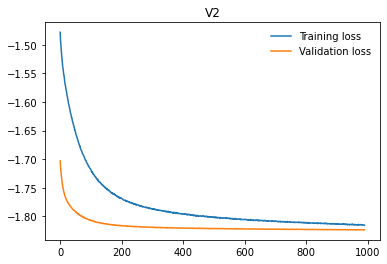

In [16]:
plt.plot(np.log10(train_losses[10:2000]), label='Training loss')
plt.plot(np.log10(valid_losses[10:2000]), label='Validation loss')
plt.legend(frameon=False)
plt.title('V2')

In [49]:
# model.load_state_dict(torch.load('NN_QST_2_KICS_20.pt'))
# model.load_state_dict(torch.load('NN_QST_2_KICS_21.pt'))
model.load_state_dict(torch.load('NN_QST_1_KICS_21.pt'))
# model.load_state_dict(torch.load('NN_QST_2_KICS_23.pt'))
# model.load_state_dict(torch.load('NN_QST_2_KICS_24.pt'))

<All keys matched successfully>

In [18]:
# track test loss on v1
test_loss = 0.0
fidelity = 0.0
if train_on_gpu:
    model.cuda()
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        with torch.no_grad():
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            for ij in range(batch_size):
                aa = np.array(output.cpu().numpy()[ij])
                bb = np.array(target.cpu().numpy()[ij])
                rho1 = state_recon_bloch_vec(optrs, aa)
                rho2 = state_recon_bloch_vec(optrs, bb)
                rho1 = eig_val_corr(rho1)
                rho2 = eig_val_corr(rho2)
                fidelity += qt.fidelity(qt.Qobj(rho1), qt.Qobj(rho2))
                
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            test_loss += loss.item()*data.size(0)
    print('Loss per Batch: {:.6f}'.format(loss))
    
# calculate average losses
test_loss = test_loss/len(test_loader.sampler)
fidelity = fidelity/len(test_loader.sampler)

# print training/validation statistics 
print('Final Test Loss: {:.6f}'.format(test_loss))
print('Average Fidelity: {:.6f}'.format(fidelity))

Loss per Batch: 0.014748
Loss per Batch: 0.015138
Loss per Batch: 0.014997
Loss per Batch: 0.014322
Loss per Batch: 0.014914
Loss per Batch: 0.015093
Loss per Batch: 0.015291
Loss per Batch: 0.014616
Loss per Batch: 0.015485
Loss per Batch: 0.014929
Loss per Batch: 0.015050
Loss per Batch: 0.014848
Loss per Batch: 0.014976
Loss per Batch: 0.014498
Loss per Batch: 0.015107
Loss per Batch: 0.014949
Loss per Batch: 0.014872
Loss per Batch: 0.014424
Loss per Batch: 0.014384
Loss per Batch: 0.014671
Final Test Loss: 0.014866
Average Fidelity: 0.866213


In [23]:
# track test loss on v2
test_loss = 0.0
fidelity = 0.0
if train_on_gpu:
    model.cuda()
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        with torch.no_grad():
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            for ij in range(batch_size):
                aa = np.array(output.cpu().numpy()[ij])
                bb = np.array(target.cpu().numpy()[ij])
                rho1 = state_recon_bloch_vec(optrs, aa)
                rho2 = state_recon_bloch_vec(optrs, bb)
                rho1 = eig_val_corr(rho1)
                rho2 = eig_val_corr(rho2)
                fidelity += qt.fidelity(qt.Qobj(rho1), qt.Qobj(rho2))
                
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            test_loss += loss.item()*data.size(0)
    print('Loss per Batch: {:.6f}'.format(loss))
    
# calculate average losses
test_loss = test_loss/len(test_loader.sampler)
fidelity = fidelity/len(test_loader.sampler)

# print training/validation statistics 
print('Final Test Loss: {:.6f}'.format(test_loss))
print('Average Fidelity: {:.6f}'.format(fidelity))

Loss per Batch: 0.015717
Loss per Batch: 0.015187
Loss per Batch: 0.015278
Loss per Batch: 0.015642
Loss per Batch: 0.014897
Loss per Batch: 0.015022
Loss per Batch: 0.015067
Loss per Batch: 0.014960
Loss per Batch: 0.015032
Loss per Batch: 0.014797
Loss per Batch: 0.015521
Loss per Batch: 0.015701
Loss per Batch: 0.015343
Loss per Batch: 0.015215
Loss per Batch: 0.016237
Loss per Batch: 0.015471
Loss per Batch: 0.015256
Loss per Batch: 0.015356
Loss per Batch: 0.015536
Loss per Batch: 0.015525
Final Test Loss: 0.015338
Average Fidelity: 0.863413


In [28]:
# track test loss on v3
test_loss = 0.0
fidelity = 0.0
if train_on_gpu:
    model.cuda()
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        with torch.no_grad():
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            for ij in range(batch_size):
                aa = np.array(output.cpu().numpy()[ij])
                bb = np.array(target.cpu().numpy()[ij])
                rho1 = state_recon_bloch_vec(optrs, aa)
                rho2 = state_recon_bloch_vec(optrs, bb)
                rho1 = eig_val_corr(rho1)
                rho2 = eig_val_corr(rho2)
                fidelity += qt.fidelity(qt.Qobj(rho1), qt.Qobj(rho2))
                
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            test_loss += loss.item()*data.size(0)
    print('Loss per Batch: {:.6f}'.format(loss))
    
# calculate average losses
test_loss = test_loss/len(test_loader.sampler)
fidelity = fidelity/len(test_loader.sampler)

# print training/validation statistics 
print('Final Test Loss: {:.6f}'.format(test_loss))
print('Average Fidelity: {:.6f}'.format(fidelity))

Loss per Batch: 0.015256
Loss per Batch: 0.015978
Loss per Batch: 0.015641
Loss per Batch: 0.014936
Loss per Batch: 0.015387
Loss per Batch: 0.015763
Loss per Batch: 0.015022
Loss per Batch: 0.015456
Loss per Batch: 0.015427
Loss per Batch: 0.015973
Loss per Batch: 0.015734
Loss per Batch: 0.015075
Loss per Batch: 0.015332
Loss per Batch: 0.015182
Loss per Batch: 0.015454
Loss per Batch: 0.015416
Loss per Batch: 0.015190
Loss per Batch: 0.015688
Loss per Batch: 0.014999
Loss per Batch: 0.014994
Final Test Loss: 0.015395
Average Fidelity: 0.861959


In [44]:
# track test loss on v4
test_loss = 0.0
fidelity = 0.0
if train_on_gpu:
    model.cuda()
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        with torch.no_grad():
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            for ij in range(batch_size):
                aa = np.array(output.cpu().numpy()[ij])
                bb = np.array(target.cpu().numpy()[ij])
                rho1 = state_recon_bloch_vec(optrs, aa)
                rho2 = state_recon_bloch_vec(optrs, bb)
                rho1 = eig_val_corr(rho1)
                rho2 = eig_val_corr(rho2)
                fidelity += qt.fidelity(qt.Qobj(rho1), qt.Qobj(rho2))
                
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            test_loss += loss.item()*data.size(0)
    print('Loss per Batch: {:.6f}'.format(loss))
    
# calculate average losses
test_loss = test_loss/len(test_loader.sampler)
fidelity = fidelity/len(test_loader.sampler)

# print training/validation statistics 
print('Final Test Loss: {:.6f}'.format(test_loss))
print('Average Fidelity: {:.6f}'.format(fidelity))

Loss per Batch: 0.015787
Loss per Batch: 0.015503
Loss per Batch: 0.016185
Loss per Batch: 0.014855
Loss per Batch: 0.015537
Loss per Batch: 0.015609
Loss per Batch: 0.015375
Loss per Batch: 0.016347
Loss per Batch: 0.015546
Loss per Batch: 0.015253
Loss per Batch: 0.015645
Loss per Batch: 0.015597
Loss per Batch: 0.015717
Loss per Batch: 0.015743
Loss per Batch: 0.015160
Loss per Batch: 0.016151
Loss per Batch: 0.015472
Loss per Batch: 0.015429
Loss per Batch: 0.015288
Loss per Batch: 0.015440
Final Test Loss: 0.015582
Average Fidelity: 0.861372


In [50]:
# track test loss on v0
test_loss = 0.0
fidelity = 0.0
if train_on_gpu:
    model.cuda()
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        with torch.no_grad():
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            for ij in range(batch_size):
                aa = np.array(output.cpu().numpy()[ij])
                bb = np.array(target.cpu().numpy()[ij])
                rho1 = state_recon_bloch_vec(optrs, aa)
                rho2 = state_recon_bloch_vec(optrs, bb)
                rho1 = eig_val_corr(rho1)
                rho2 = eig_val_corr(rho2)
                fidelity += qt.fidelity(qt.Qobj(rho1), qt.Qobj(rho2))
                
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            test_loss += loss.item()*data.size(0)
    print('Loss per Batch: {:.6f}'.format(loss))
    
# calculate average losses
test_loss = test_loss/len(test_loader.sampler)
fidelity = fidelity/len(test_loader.sampler)

# print training/validation statistics 
print('Final Test Loss: {:.6f}'.format(test_loss))
print('Average Fidelity: {:.6f}'.format(fidelity))

Loss per Batch: 0.013896
Loss per Batch: 0.014144
Loss per Batch: 0.013346
Loss per Batch: 0.013323
Loss per Batch: 0.013234
Loss per Batch: 0.013995
Loss per Batch: 0.014145
Loss per Batch: 0.014581
Loss per Batch: 0.013522
Loss per Batch: 0.014386
Loss per Batch: 0.013901
Loss per Batch: 0.013970
Loss per Batch: 0.014480
Loss per Batch: 0.014131
Loss per Batch: 0.014090
Loss per Batch: 0.013350
Loss per Batch: 0.013228
Loss per Batch: 0.013289
Loss per Batch: 0.013803
Loss per Batch: 0.014040
Final Test Loss: 0.013843
Average Fidelity: 0.873512


Trained on v1 for 1000 epochs with 1000 copies and 10,000 data points

#v0       
Final Test Loss: 0.013843     
Average Fidelity: 0.873512

#v1   
Final Test Loss: 0.014866    
Average Fidelity: 0.866213
    
#v2   
Final Test Loss: 0.015338     
Average Fidelity: 0.863413 
    
#v3   
Final Test Loss: 0.015395     
Average Fidelity: 0.861959
    
#v4   
Final Test Loss: 0.015582     
Average Fidelity: 0.861372